## Plot mean spectra over scatter plots with automated box location

In [9]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from sklearn.cluster import KMeans
from astroML.plotting import setup_text_plots
import h5py
from scipy.io import mmread

np.set_printoptions(suppress=True)
setup_text_plots(fontsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=16, family='serif', style='normal', variant='normal', stretch='normal', weight='bold')
mpl.rc('legend', labelspacing=0.1, handlelength=2, fontsize=10)
mpl.rc('axes', labelweight='black')

In [24]:
# load the data -- first get indices in main component of embedding 
f = h5py.File('labels_1e4_randsamp_age_model_spectra.mtx','r')
labels = f['labels'][:]
n = f['n_components'][:]
f.close()

wh = labels == 0

# now get the model spectra
f = h5py.File('../data/1e4_randsamp_age_model_spectra.hdf5','r')
spectra = f['spectra'][wh,:]
wave = f['wave'][:]
taus = f['taus'][wh]
ages = f['ages'][wh]
zs = f['zs'][wh]
dusts = f['dusts'][wh]
sigmas = f['sigmas'][wh]
f.close()

# now embedding
embed = mmread('embed3d_1e4_randsamp_age_model_spectra.mtx')
embed = embed[wh,:]

In [68]:
"""
Copy and modify a bunch of functions from trident_arms.ipynb in the emebdsdss directory
"""
def make_cc_plot(color, label, axlim=None):
    # axlim is a list of [min,max] for dim0, dim2, dim1 (left x, right x, mutual y axes)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    a = ax[0].scatter(embed[:,0], embed[:,1], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(a, ax=ax[0], label=label)
    ax[0].set_xlabel('dim0')
    ax[0].set_ylabel('dim1')

    b = ax[1].scatter(embed[:,2], embed[:,1], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(b, ax=ax[1], label=label)
    ax[1].set_xlabel('dim2')
    ax[1].set_ylabel('dim1')
    
    if axlim is not None:
        ax[0].set_xlim(axlim[0])
        ax[0].set_ylim(axlim[2])
        ax[1].set_xlim(axlim[1])
        ax[1].set_ylim(axlim[2])
        
    plt.tight_layout()
    return fig, ax

def make_cc_plot_single(color, label, xax=1, axlim=None):
    # axlim is a list of [min,max] for dim0, dim2, dim1 (left x, right x, mutual y axes)
    # HACK to get only the right panel as a single, larger plot (for now!)
    fig, ax = plt.subplots(figsize=(10,8))

    b = ax.scatter(embed[:,xax], embed[:,1], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(b, ax=ax, label=label)
    ax.set_xlabel('dim2')
    ax.set_ylabel('dim1')
    
    if axlim is not None:
        ax.set_xlim(axlim[xax])
        ax.set_ylim(axlim[2])
        
    plt.tight_layout()
    return fig, ax

def get_mean_spectrum(embed, xlow, ylow, width, xdim=2, ydim=1):
    use = (embed[:,xdim] > xlow) * (embed[:,xdim] < xlow + width) * (embed[:,ydim] > ylow) * \
            (embed[:,ydim] < ylow + width)
    if np.sum(use) == 0:
        stack = np.zeros(spectra.shape[1])

    else:
        #indices = np.unique(pc_inds.ravel()[use])
        #boxspectra = f['spectra'][indices.tolist()]
        boxspectra = spectra[use]
        stack = np.mean(boxspectra, axis=0)
    return stack

def add_subplot_axes(ax,rect): #,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]
    subax = fig.add_axes([x,y,width,height]) #,axisbg=axisbg)
    subax.patch.set_alpha(0.5)
    subax.get_xaxis().set_visible(False)
    subax.get_yaxis().set_visible(False)
    #x_labelsize = subax.get_xticklabels()[0].get_size()
    #y_labelsize = subax.get_yticklabels()[0].get_size()
    #x_labelsize *= rect[2]**0.5
    #y_labelsize *= rect[3]**0.5
    #subax.xaxis.set_tick_params(labelsize=x_labelsize)
    #subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax
 
def change_coordinates(ax, pos):
    # want to go from coordinates in subplot to [0,1] coordinates
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    subpos = []
    subpos.append((pos[0]-xlim[0]) / (xlim[1]-xlim[0]))
    subpos.append((pos[1]-ylim[0]) / (ylim[1]-ylim[0]))
    subpos.append(pos[2] / (xlim[1]-xlim[0]))
    subpos.append(pos[3] / (ylim[1]-ylim[0]))
    return subpos

def overplot_spectra(centers, xax=1, width=0.0005): #shit, this is totally going to be the bottom/left corners, not centers
    #fig, ax = make_cc_plot(ages, r'Age', axlim=[[-0.002,0.008],[-0.008,0.005],[-0.005,0.006]])
    fig, ax = make_cc_plot_single(dusts, r'Dust', xax=xax, axlim=[[-0.002,0.008],[-0.006,0.004],[-0.004,0.005]])
    #ax = ax[1] # just do this for the right panel for now
    xs = centers[:,xax]
    ys = centers[:,1]
    
    for ii in range(len(xs)):
        pos = [xs[ii], ys[ii], width, width]
        subpos = change_coordinates(ax, pos)
        subax = add_subplot_axes(ax, subpos)
        stack = get_mean_spectrum(embed, xs[ii], ys[ii], width, xdim=xax)
        subax.plot(wave, stack, 'k-')

In [29]:
def get_box_centers(embed):
    # add a check to make sure the cluster centers aren't closer than the box sizes
    kmeans = KMeans(n_clusters=10).fit(embed)
    return kmeans.cluster_centers_

In [31]:
centers = get_box_centers(embed)

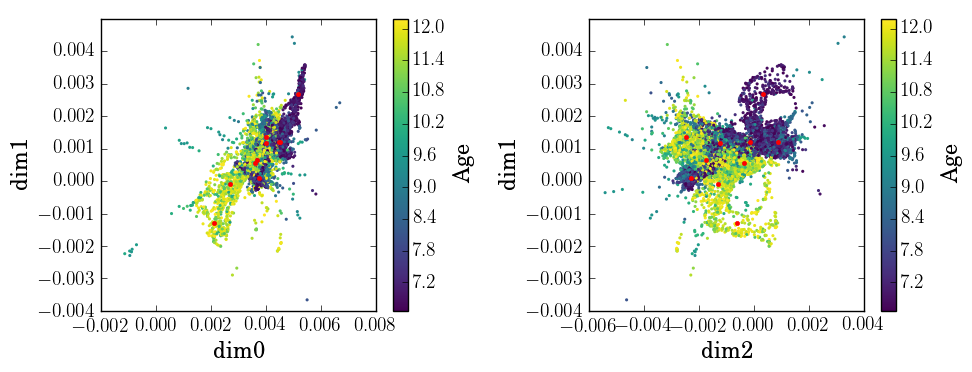

In [56]:
fig, ax = make_cc_plot(ages, r'Age', axlim=[[-0.002,0.008],[-0.006,0.004],[-0.004,0.005]])
ax[0].plot(centers[:,0], centers[:,1], 'r.')
ax[1].plot(centers[:,2], centers[:,1], 'r.')

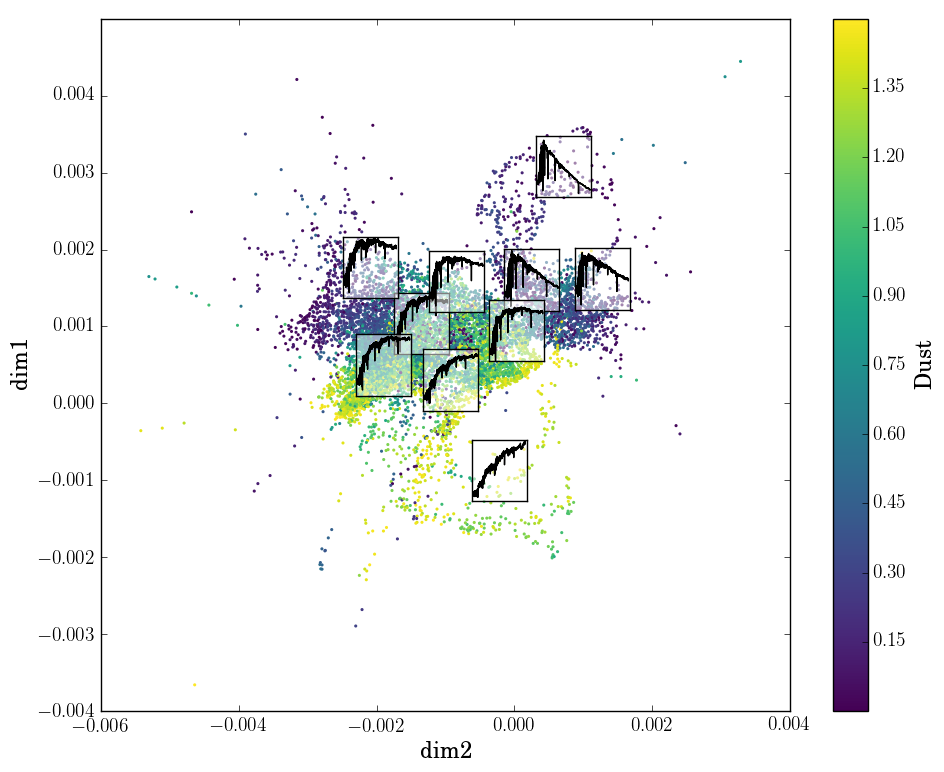

In [61]:
overplot_spectra(centers, width=0.0008)

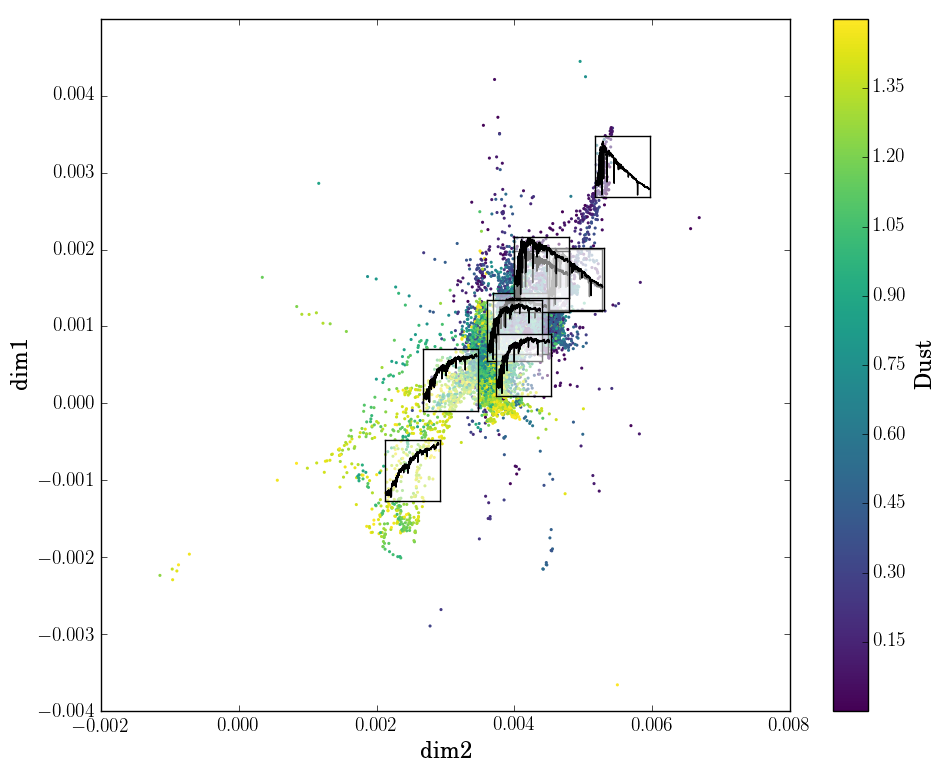

In [69]:
overplot_spectra(centers, xax=0, width=0.0008)